In [1]:
import sys
from pathlib import Path

ROOT = Path('/Users/raghavv/Desktop/pythonstuff/biol4559/project')
sys.path.insert(0, str(ROOT / 'bipartiteSBM'))
sys.path.insert(0, str(ROOT))

print('sys.path updated')

sys.path updated


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import polars as pl
import pandas as pd

In [3]:
df = pl.read_csv("hosts.csv", encoding="utf8-lossy", ignore_errors=True, null_values=["NA", ""], infer_schema_length=0)
filtered_ape = df.filter(
    (pl.col("hOrder") == "PRIMATES") &
    (pl.col("hHostNameFinal") != "Homo_sapiens") #excluding humans cuz it's a huge outlier
)


print(filtered_ape.select(["hHostNameFinal", "hOrder"]))

df2 = df = pl.read_csv("associations.csv", encoding="utf8-lossy", ignore_errors=True, null_values=["NA", ""], infer_schema_length=0)


filtered_ape_list = filtered_ape["hHostNameFinal"].to_list()
df2_ape = df2.filter(pl.col("hHostNameFinal").is_in(filtered_ape_list))

filtered_df2_ape = df2_ape.select(["hHostNameFinal", "vVirusNameCorrected", "DetectionQuality"])

print(filtered_df2_ape)


shape: (97, 2)
┌─────────────────────────────┬──────────┐
│ hHostNameFinal              ┆ hOrder   │
│ ---                         ┆ ---      │
│ str                         ┆ str      │
╞═════════════════════════════╪══════════╡
│ Allenopithecus_nigroviridis ┆ PRIMATES │
│ Alouatta_caraya             ┆ PRIMATES │
│ Alouatta_palliata           ┆ PRIMATES │
│ Alouatta_pigra              ┆ PRIMATES │
│ Alouatta_seniculus          ┆ PRIMATES │
│ …                           ┆ …        │
│ Theropithecus_gelada        ┆ PRIMATES │
│ Trachypithecus_cristatus    ┆ PRIMATES │
│ Trachypithecus_francoisi    ┆ PRIMATES │
│ Trachypithecus_obscurus     ┆ PRIMATES │
│ Varecia_variegata           ┆ PRIMATES │
└─────────────────────────────┴──────────┘
shape: (332, 3)
┌─────────────────────────────┬─────────────────────────────────┬──────────────────┐
│ hHostNameFinal              ┆ vVirusNameCorrected             ┆ DetectionQuality │
│ ---                         ┆ ---                             ┆ --

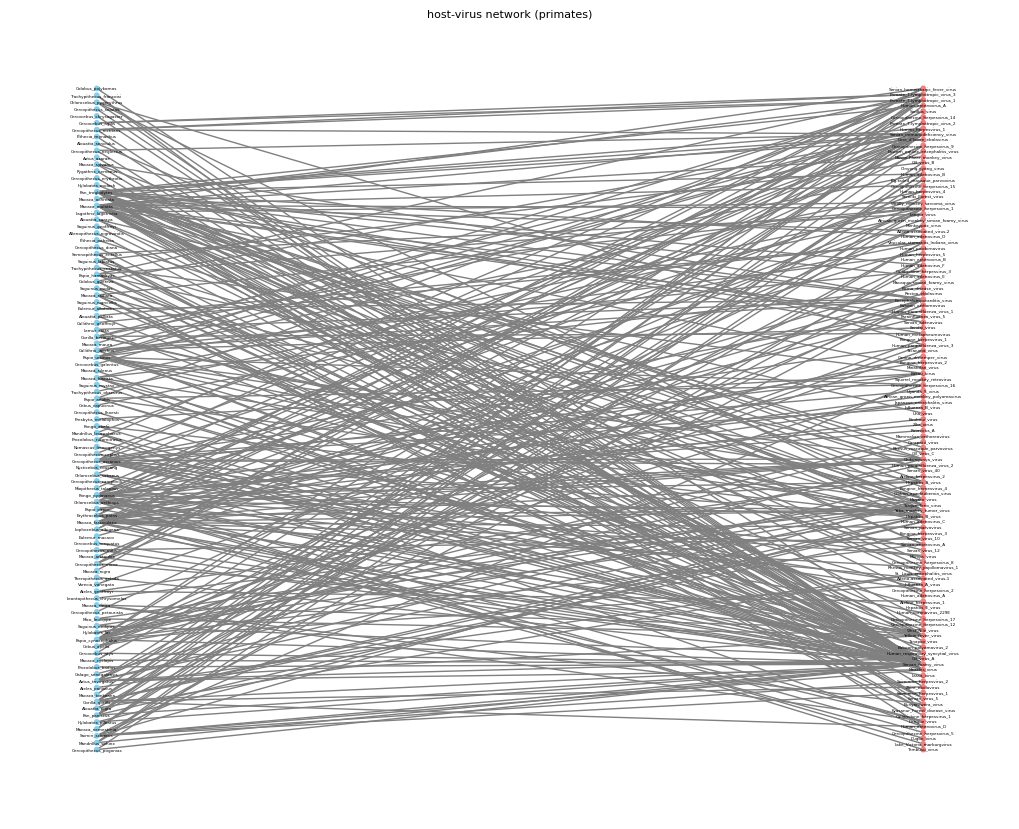

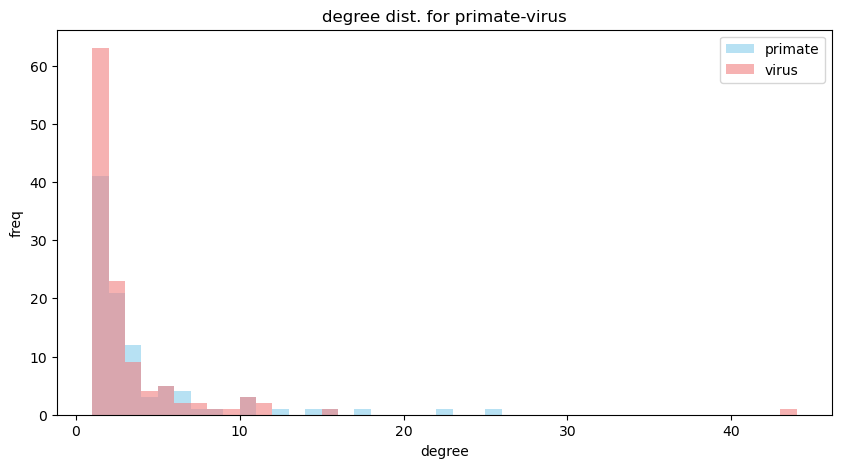

top primates by degree:
Pan_troglodytes: 25
Macaca_mulatta: 22
Macaca_fascicularis: 17
Pongo_pygmaeus: 15
Cercopithecus_ascanius: 14
Papio_cynocephalus: 12
Gorilla_gorilla: 10
Papio_ursinus: 10
Chlorocebus_aethiops: 10
Aotus_trivirgatus: 8
top viruses by degree:
Simian_foamy_virus: 43
Simian_immunodeficiency_virus: 15
Yellow_fever_virus: 11
Measles_virus: 11
Hepatitis_B_virus: 10
Primate_T-lymphotropic_virus_1: 10
Encephalomyocarditis_virus: 10
Chikungunya_virus: 9
Cercopithecine_herpesvirus_1: 8
Yaba_monkey_tumor_virus: 7
14059
326
0.09275197382459634


In [4]:
G_ape = nx.Graph()
G_ape.add_nodes_from(df2_ape["hHostNameFinal"], bipartite=0) 
G_ape.add_nodes_from(df2_ape["vVirusNameCorrected"], bipartite=1)
edge_list_ape = df2_ape.select(["hHostNameFinal", "vVirusNameCorrected"]).rows()
G_ape.add_edges_from(edge_list_ape)


hosts_ape = df2_ape["hHostNameFinal"].unique().to_list()
viruses_ape = df2_ape["vVirusNameCorrected"].unique().to_list()

pos_ape = nx.bipartite_layout(G_ape, hosts_ape)
plt.figure(figsize=(10, 8))
nx.draw(
    G_ape,
    pos_ape,
    with_labels=True,
    node_color=["skyblue" if n in hosts_ape else "lightcoral" for n in G_ape.nodes()],
    node_size=10,
    edge_color="gray",
    font_size=3
)

plt.title("host-virus network (primates)", fontsize=8, pad=1)

plt.show()

host_degrees_p = [G_ape.degree(n) for n in hosts_ape]
virus_degrees_p = [G_ape.degree(n) for n in viruses_ape]

plt.figure(figsize=(10,5))

plt.hist(host_degrees_p, bins=range(1, max(host_degrees_p)+2), alpha=0.6, label="primate", color="skyblue")
plt.hist(virus_degrees_p, bins=range(1, max(virus_degrees_p)+2), alpha=0.6, label="virus", color="lightcoral")

plt.xlabel("degree")
plt.ylabel("freq")
plt.title("degree dist. for primate-virus")
plt.legend()
plt.show()

degree_dict_p = dict(G_ape.degree())
ape_degrees = {n: degree_dict_p[n] for n in hosts_ape}
pvirus_degrees = {n: degree_dict_p[n] for n in viruses_ape}
sorted_ape = sorted(ape_degrees.items(), key=lambda x: x[1], reverse=True)
psorted_viruses = sorted(pvirus_degrees.items(), key=lambda x: x[1], reverse=True)

print("top primates by degree:")
for n, d in sorted_ape[:10]:
    print(f"{n}: {d}")

print("top viruses by degree:")
for n, d in psorted_viruses[:10]:
    print(f"{n}: {d}")

path3p = sum((degree_dict_p[u]-1)*(degree_dict_p[v]-1) for u, v in G_ape.edges()) #3 paths
print(path3p)


from itertools import combinations

p_nbrs = {u: set(G_ape.neighbors(u)) for u in hosts_ape}
cycle4p = 0
for u1, u2 in combinations(hosts_ape, 2):
    c = len(p_nbrs[u1] & p_nbrs[u2])
    cycle4p += c*(c-1)//2    #4 cycles
print(cycle4p)

cc_p = (4 * cycle4p) / path3p
print(cc_p)





In [5]:

x, y = [], [] #create the list x and y
for u, v in G_ape.edges():  #putting degrees into x and y
    if u in hosts_ape:         
        x.append(degree_dict_p[u])
        y.append(degree_dict_p[v])
    else:                      
        x.append(degree_dict_p[v])
        y.append(degree_dict_p[u])

x = np.array(x, dtype=float) #convert list into numpy array
y = np.array(y, dtype=float)



r_monk = np.corrcoef(x, y)[0, 1]
print(f"pearson corr for primate–virus: {r_monk:}") 


pearson corr for primate–virus: -0.2919945239108622


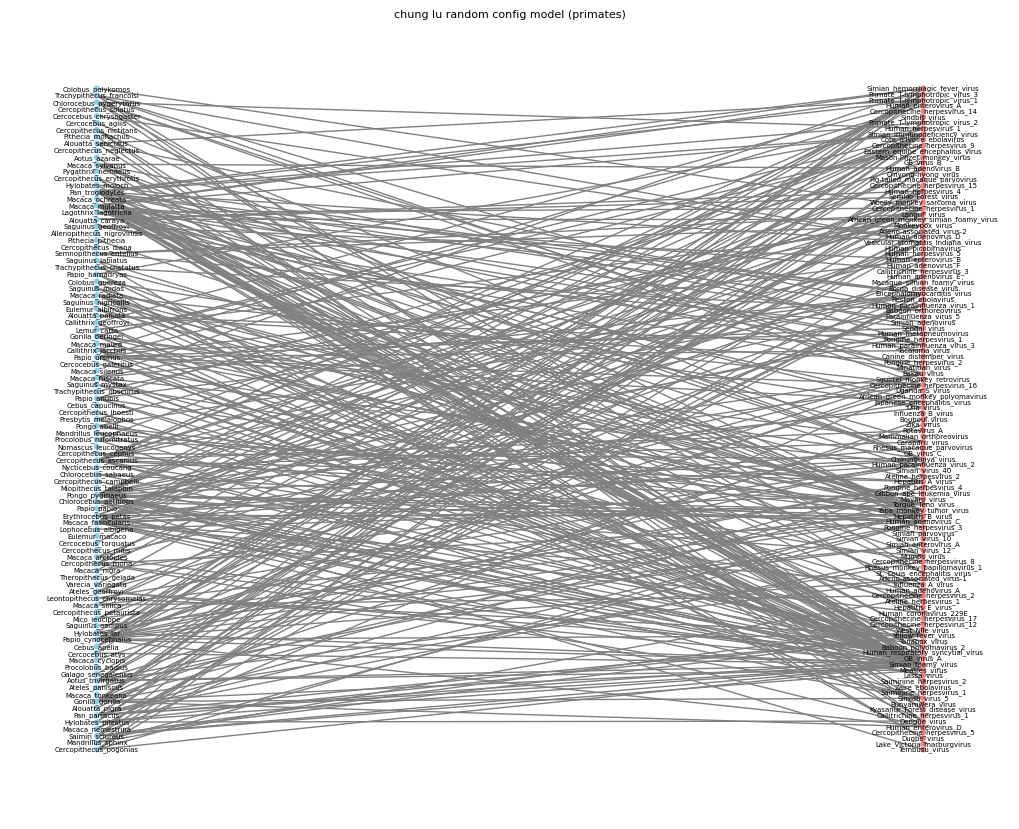

In [6]:
def chung_lu_bipartite_graph(G_ape, hosts, viruses, seed=0):
    rng = np.random.default_rng(seed)

    dU = np.fromiter((G_ape.degree(u) for u in hosts), dtype=float)
    dV = np.fromiter((G_ape.degree(v) for v in viruses), dtype=float)

    mU, mV = dU.sum(), dV.sum()
    if mU == 0 or mV == 0:
        H = nx.Graph()
        H.add_nodes_from(hosts, bipartite=0)
        H.add_nodes_from(viruses, bipartite=1)
        return H  

    m = (mU + mV) / 2.0
    p = np.outer(dU, dV) / m
    np.clip(p, 0.0, 1.0, out=p)

    A = rng.random(p.shape) < p
    ui, vj = np.nonzero(A)

    H = nx.Graph()
    H.add_nodes_from(hosts, bipartite=0)
    H.add_nodes_from(viruses, bipartite=1)
    H.add_edges_from((hosts[i], viruses[j]) for i, j in zip(ui, vj))
    return H


H_null = chung_lu_bipartite_graph(G_ape, hosts_ape, viruses_ape, seed=4)
pos = nx.bipartite_layout(H_null, hosts_ape)
plt.figure(figsize=(10, 8))
nx.draw(
    H_null,
    pos,
    with_labels=True,
    node_color=["skyblue" if n in hosts_ape else "lightcoral" for n in H_null.nodes()],
    node_size=10,
    edge_color="gray",
    font_size=5
)

plt.title("chung lu random config model (primates)", fontsize=8, pad=1)
plt.show()



In [7]:
#need pearson for null model

In [8]:
print("avg primate degree:", sum(ape_degrees.values())/len(ape_degrees.values()))

print("avg primate virus degree:", sum(pvirus_degrees.values())/len(pvirus_degrees.values())) #within the category of rodents/primates

print("clustering coeff. primate:", cc_p)

print(f"pearson corr for primate–virus: {r_monk:}") 

avg primate degree: 3.402061855670103
avg primate virus degree: 2.8205128205128207
clustering coeff. primate: 0.09275197382459634
pearson corr for primate–virus: -0.2919945239108622
